In [1]:
import matplotlib
import multiprocessing
import numpy as np
import pymc3 as pm
import scipy
import seaborn as sns
import tabulate
import theano
import theano.tensor as tt

# Enable on-the-fly graph computations, but ignore absence of intermediate test values.
theano.config.compute_test_value = 'ignore'

matplotlib.rcParams['figure.figsize'] = (mt.plots.DEFAULT_PLOT_SIZE * 1.5, mt.plots.DEFAULT_PLOT_SIZE)

DAYS_PER_YEAR = 250

returns = pd.DataFrame.from_csv('returns.csv')
returns.head()

def plot_cov(returns, trace, figsize=(12, 9), vmin=.05, vmax=.25):

    historical_cov_sqrt_df = (returns.cov() * DAYS_PER_YEAR) ** .5

    bayesian_cov_sqrt_df = pd.DataFrame(
        data    = (trace.get_values('cov').mean(axis=0) * DAYS_PER_YEAR) ** .5, 
        index   = returns.columns,
        columns = returns.columns
    )

    _, ax = sns.plt.subplots(figsize=figsize)
    ax = sns.heatmap(data=historical_cov_sqrt_df, vmin=vmin, vmax=vmax)
    ax.set_title('Historical Covariance')

    _, ax = sns.plt.subplots(figsize=figsize)
    ax = sns.heatmap(data=bayesian_cov_sqrt_df, vmin=vmin, vmax=vmax)
    ax.set_title('Bayesian Covariance')

    _, ax = sns.plt.subplots(figsize=figsize)
    ax = sns.heatmap(data=historical_cov_sqrt_df - bayesian_cov_sqrt_df)
    ax.set_title('Correlation Differences (Historical - Bayesian)')

,RSP,QVAL,SYLD,BRK_A,IVAL,GVAL,FYLD,QMOM,GMOM,IMOM
Date,,,,,,,,,,
2016-01-04,-0.011088,-0.004047,-0.016943,-0.007576,-0.007585,-0.011664,-0.011718,-0.031732,-0.010167,-0.013003
2016-01-05,0.001837,-0.000913,0.004255,0.001934,-0.009704,-0.003053,-0.005044,0.005691,0.003104,-0.003194
2016-01-06,-0.018301,-0.024857,-0.016480,0.003365,-0.022070,-0.017728,-0.014687,-0.011752,-0.001775,-0.017221
2016-01-07,-0.022392,-0.010121,-0.017815,-0.011251,-0.018267,-0.006236,-0.017028,-0.022859,-0.003556,-0.011410
2016-01-08,-0.011801,-0.032095,-0.016354,-0.008396,-0.004832,-0.007844,-0.004209,-0.017084,-0.003614,-0.000824


/Users/jonathanng/anaconda/lib/python3.6/site-packages/theano/tensor/var.py:507: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if(inp == [] or inp == ()) else inp for inp in args])
/Users/jonathanng/anaconda/lib/python3.6/site-packages/theano/tensor/var.py:507: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if(inp == [] or inp == ()) else inp for inp in args])
/Users/jonathanng/anaconda/lib/python3.6/site-packages/theano/tensor/var.py:507: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if(inp == [] or inp == ()) else inp for inp in args])
/Users/jonathanng/anaconda/lib/python3.6/site-packages/theano/tensor/var.py:507: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if(inp == [] or inp == ()) else inp for inp in args])
/Users/jonathanng/anaconda/lib/python3.6/site-packages/theano/tensor/var.py:


sd:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.008            0.000            0.000            [0.007, 0.008]
  0.010            0.000            0.000            [0.009, 0.011]
  0.008            0.000            0.000            [0.008, 0.009]
  0.008            0.000            0.000            [0.008, 0.009]
  0.011            0.000            0.000            [0.010, 0.012]
  0.011            0.000            0.000            [0.010, 0.011]
  0.010            0.000            0.000            [0.009, 0.010]
  0.010            0.000            0.000            [0.010, 0.011]
  0.005            0.000            0.000            [0.005, 0.005]
  0.010            0.000            0.000            [0.009, 0.011]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.007      

/Users/jonathanng/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:


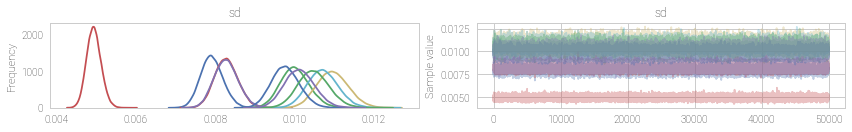

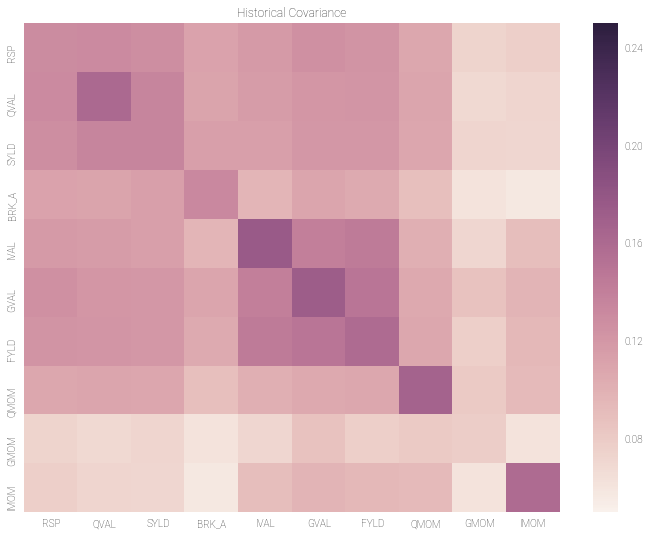

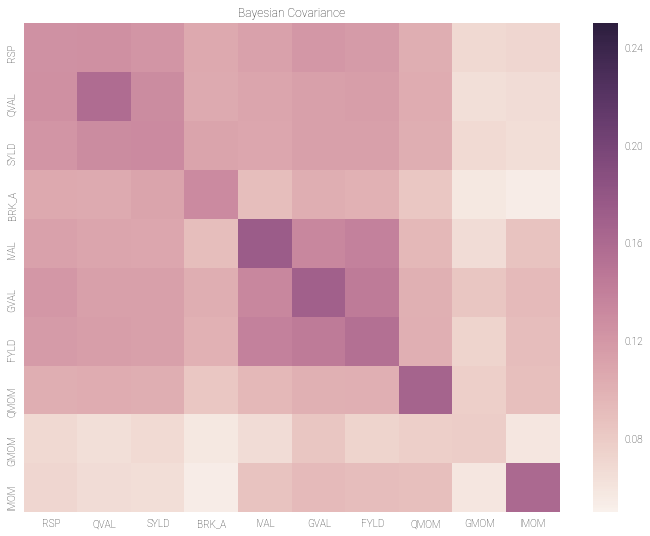

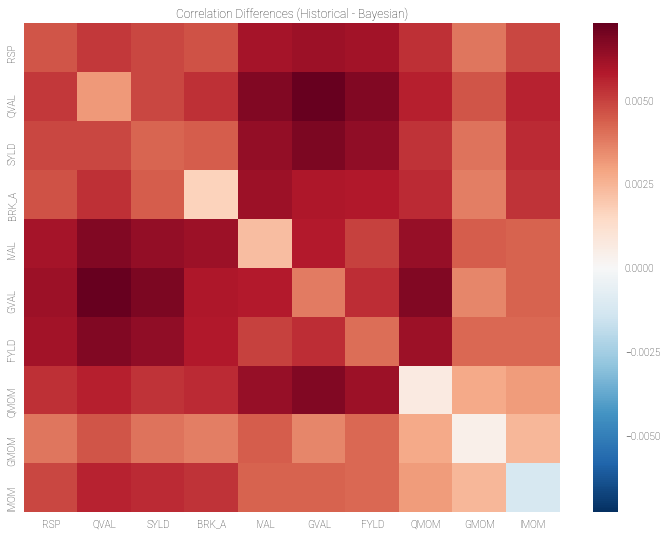

In [2]:
def correlation(dataset, verbose=0, draws=10000, target_accept=0.90, sample_init='advi', cpu_count=multiprocessing.cpu_count()):
    '''
    ## References
    - https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/LKJ.ipynb

    ## Old References
    - http://nbviewer.jupyter.org/github/sebp/bayesian-correlation/blob/master/bayesian_correlation_pymc3.ipynb
    - https://github.com/pymc-devs/pymc3/blob/master/pymc3/examples/LKJ_correlation.py
    '''

    n_var = dataset.shape[1]

    with pm.Model() as model:

        mu = pm.Normal(
            name  = 'mu',
            mu    = 0,
            sd    = 1,
            shape = n_var
        )

        # The shape parameter (eta > 0) of the LKJ distribution. eta = 1
        # implies a uniform distribution of the correlation matrices;
        # larger values put more weight on matrices with few correlations.
        # Note that we access the distribution for the standard
        # deviations, and do not create a new random variable.
        packed_chol = pm.LKJCholeskyCov(
            name    = 'chol_cov',
            n       = n_var,
            eta     = 1,
            sd_dist = pm.HalfCauchy.dist(beta=2.5)
        )

        # Convert a packed triangular matrix into a two dimensional array.
        chol = pm.expand_packed_triangular(n=n_var, packed=packed_chol, lower=True)

        # Extract the standard deviations and correlations (rho)
        cov  = pm.Deterministic('cov', tt.dot(chol, chol.T))  # Compute the covariance matrix
        sd   = pm.Deterministic('sd', tt.sqrt(tt.diag(cov)))
        corr = tt.diag(sd**-1).dot(cov.dot(tt.diag(sd**-1)))
        rho  = pm.Deterministic('rho', corr[np.triu_indices(n_var, k=1)])

        likelihood = pm.MvNormal(
            name     = 'likelihood',
            mu       = mu,
            chol     = chol,
            observed = dataset
        )

        trace = pm.sample(
            draws            = draws / cpu_count,
            init             = sample_init,
            n_init           = 150000,
            progressbar      = verbose > 0,
            njobs            = cpu_count,
            nuts_kwargs      = {'target_accept': target_accept},
            # live_plot        = verbose > 0,
            # live_plot_kwargs = {'varnames': ['mu', 'sd'], 'combined': True},
        )

    if verbose > 0:

        pm.summary(trace=trace, varnames=['sd'])

        pm.traceplot(
            trace    = trace,
            varnames = ['sd'],
            combined = True
        )

    return model, trace

correlation_model, correlation_trace = correlation(
    dataset   = returns,
    draws     = 50000,
    cpu_count = 1,
    verbose   = 1
)

plot_cov(returns=returns, trace=correlation_trace)

Given:
- $M$: number of stocks
- $D$: number of factors
- $N$: length of time
- $R$: realized stock returns

Model:`
- $\underset{M\times D}{V} \sim \mathcal{N}\left ( 0, \sigma _{V} \right )$: factor weights
- $\underset{N\times D}{U} \sim \mathcal{N}\left ( 0, \sigma _{U} \right )$: factor returns
- $\underset{N\times M}{R} \sim \mathcal{N}\left ( UV^{T}, \sigma \right )$: stock returns

Having small $\sigma _{V}$ and $\sigma _{U}$ prevents overfitting, and is called complexity control.

Resources:
1. https://pymc-devs.github.io/pymc3/notebooks/pmf-pymc.html

Average Loss = -12,741:  30%|██▉       | 44672/150000 [00:13<00:31, 3343.30it/s]  
100%|█████████▉| 50496/50500.0 [06:27<00:00, 65.55it/s] /Users/jonathanng/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.113851561513, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 50500/50500.0 [06:27<00:00, 130.45it/s]



stock_std:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.008            0.000            0.000            [0.008, 0.009]
  0.010            0.000            0.000            [0.010, 0.011]
  0.009            0.000            0.000            [0.008, 0.009]
  0.008            0.000            0.000            [0.008, 0.009]
  0.011            0.000            0.000            [0.010, 0.012]
  0.011            0.000            0.000            [0.010, 0.012]
  0.010            0.000            0.000            [0.009, 0.011]
  0.010            0.000            0.000            [0.010, 0.011]
  0.005            0.000            0.000            [0.005, 0.005]
  0.010            0.000            0.000            [0.009, 0.011]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.00

/Users/jonathanng/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:


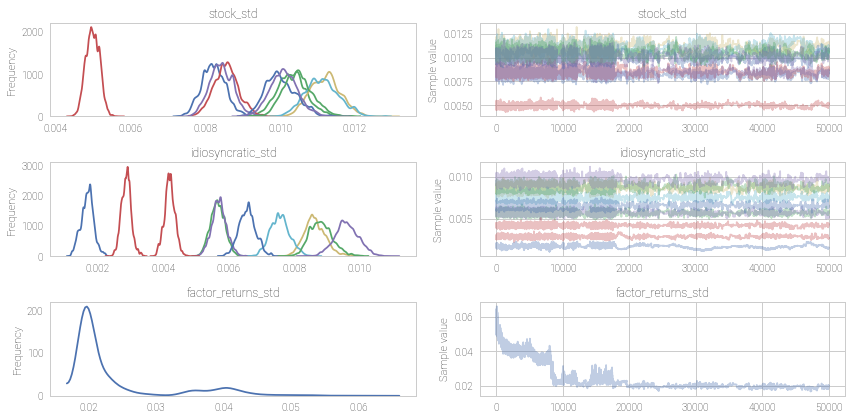

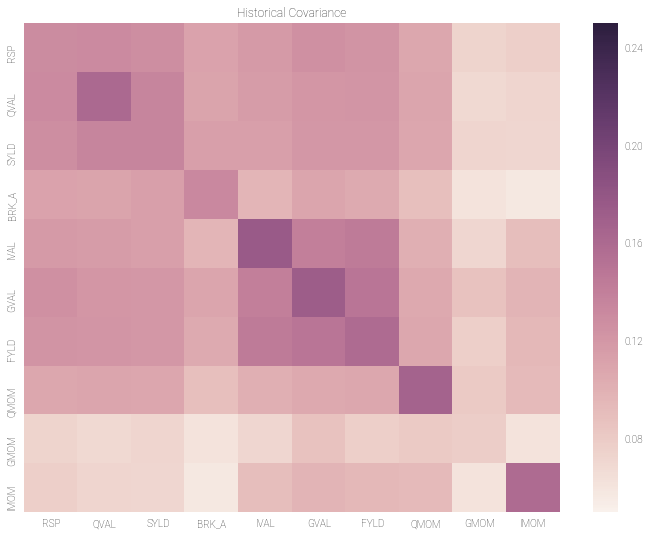

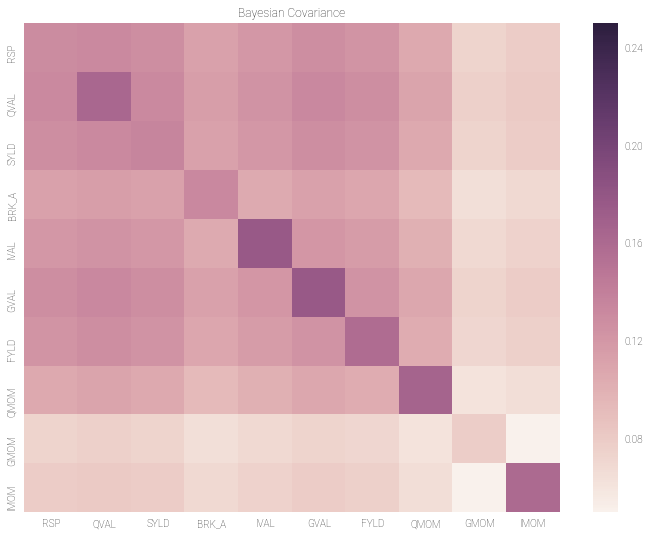

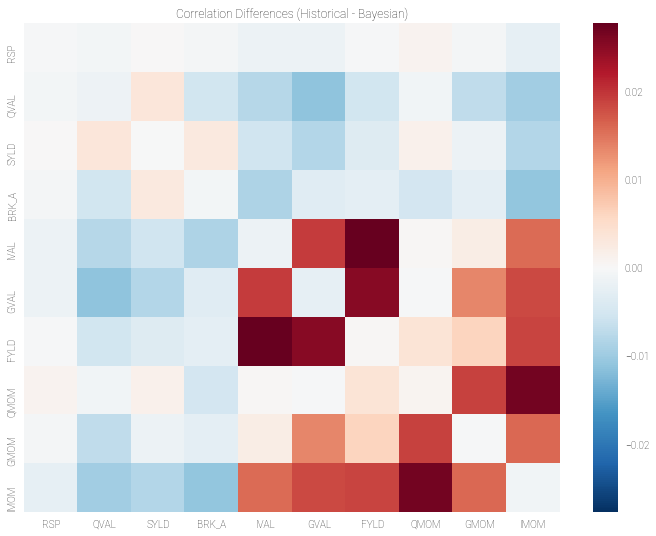

In [3]:
def factors(dataset, n_factors=1, verbose=0, draws=50000, sample_init='advi', cpu_count=multiprocessing.cpu_count()):
    '''
    ## References
    - https://pymc-devs.github.io/pymc3/notebooks/pmf-pymc.html
    '''

    data        = dataset.values.copy()
    T, n_stocks = data.shape

    with pm.Model() as model:

        # U        
        factor_returns_std = pm.HalfCauchy(
            name    = 'factor_returns_std',
            beta    = data.std(axis=1).mean(),
            testval = data.std(axis=1).mean()
        )

        factor_returns = pm.Normal(
            name    = 'factor_returns',
            mu      = 0,
            sd      = factor_returns_std,
            shape   = (T, n_factors),
            testval = np.random.randn(T, n_factors) * factor_returns_std
        )

        # V
#         beta_std = pm.HalfCauchy(
#             name    = 'beta_std',
#             beta    = 1.0,
#             testval = 1.0
#         )
        
        beta_std = 1.0
    
        beta = pm.Normal(
            name    = 'beta',
            mu      = 1.0,
            sd      = beta_std,
            shape   = (n_stocks, n_factors),
            testval = np.random.randn(n_stocks, n_factors) * beta_std
        )

        # R
        idiosyncratic_std = pm.HalfCauchy(
            name    = 'idiosyncratic_std',
            beta    = data.std(axis=1).mean(),
            shape   = n_stocks,
            testval = data.std(axis=1).mean()
        )
        
        stock_returns = pm.Normal(
            name     = 'stock_returns',
            mu       = tt.dot(factor_returns, beta.T),
            sd       = idiosyncratic_std,
            observed = data
        )

        cov = pm.Deterministic(
            name = 'cov',
            var  = factor_returns_std ** 2 * tt.dot(beta, beta.T) + (idiosyncratic_std ** 2) * np.eye(n_stocks)
        )

        stock_std = pm.Deterministic(
            name = 'stock_std',
            var  = tt.sqrt(tt.diag(cov))
        )

        trace = pm.sample(
            draws            = draws / cpu_count,
            init             = sample_init,
            n_init           = 150000,
            progressbar      = verbose > 0,
            njobs            = cpu_count,
            # live_plot        = verbose > 0,
            # live_plot_kwargs = {'varnames': ['mu', 'sd'], 'combined': True},
        )

    if verbose > 0:

        pm.summary(trace=trace, varnames=['stock_std', 'idiosyncratic_std', 'factor_returns_std'])

        pm.traceplot(
            trace    = trace,
            varnames = ['stock_std', 'idiosyncratic_std', 'factor_returns_std'],
#             combined = True
        )
        
    return model, trace


factor_model, factor_trace = factors(
    dataset     = returns,
    n_factors   = 1,
    draws       = 50000,
    sample_init = 'advi',
    verbose     = 1,
    cpu_count   = 1
)

plot_cov(returns=returns, trace=factor_trace)

In [ ]:
pm.dic(correlation_trace, correlation_model)
pm.dic(factor_trace, factor_model)

-26293.74114359299

-28301.474498022799

In [ ]:
pm.compare(
    traces = (correlation_trace, factor_trace),
    models = (correlation_model, factor_model),
    ic     = 'WAIC'
)

pm.compare(
    traces = (correlation_trace, factor_trace),
    models = (correlation_model, factor_model),
    ic     = 'LOO'
)

ValueError: could not broadcast input array from shape (356) into shape (3560)

> /Users/jonathanng/anaconda/lib/python3.6/site-packages/pymc3/stats.py(433)compare()
    431         ic_i = np.zeros((len(ics), N))
    432         for i in range(len(ics)):
--> 433             ic_i[i] = ics[i][1][3] * N
    434 
    435         b_weighting = dirichlet.rvs(alpha=[alpha] * N, size=b_samples,

